<a href="https://colab.research.google.com/github/pko89403/Recsys_test/blob/master/char_rnn_classification_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

각각의 파일은 이름 뭉치들을 가지고 있고, 한 줄 당 한 이름

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os 



def fineFiles(path): return glob.glob(path)

data_path = "/content/drive/My Drive/data/classify_names"
print(fineFiles(data_path + '/names/*.txt'))

['/content/drive/My Drive/data/classify_names/names/Italian.txt', '/content/drive/My Drive/data/classify_names/names/Scottish.txt', '/content/drive/My Drive/data/classify_names/names/Polish.txt', '/content/drive/My Drive/data/classify_names/names/Dutch.txt', '/content/drive/My Drive/data/classify_names/names/Portuguese.txt', '/content/drive/My Drive/data/classify_names/names/Korean.txt', '/content/drive/My Drive/data/classify_names/names/Greek.txt', '/content/drive/My Drive/data/classify_names/names/Irish.txt', '/content/drive/My Drive/data/classify_names/names/Vietnamese.txt', '/content/drive/My Drive/data/classify_names/names/French.txt', '/content/drive/My Drive/data/classify_names/names/Arabic.txt', '/content/drive/My Drive/data/classify_names/names/Japanese.txt', '/content/drive/My Drive/data/classify_names/names/Russian.txt', '/content/drive/My Drive/data/classify_names/names/German.txt', '/content/drive/My Drive/data/classify_names/names/Chinese.txt', '/content/drive/My Drive/da

In [0]:
import unicodedata
import string

In [0]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

유니코드 문자열을 아스키로 변환한다

In [4]:
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )

print(unicodeToAscii('Ślusàrski'))

Slusarski


카테고리 라인 사전을 구축한다, 랭기지 별 네임 리스트

In [0]:
category_lines = {}
all_categories = []

def readLines(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in fineFiles(data_path + '/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)

In [6]:
print(all_categories)

['Italian', 'Scottish', 'Polish', 'Dutch', 'Portuguese', 'Korean', 'Greek', 'Irish', 'Vietnamese', 'French', 'Arabic', 'Japanese', 'Russian', 'German', 'Chinese', 'Spanish', 'English', 'Czech']


이름을 사용하려면 당연히 텐서로 변형해야한다    
싱글 글자를 표현하기 위해, 원-핫 벡터를 사용한다.

In [7]:
import torch

def letterToIndex(letter):
  return all_letters.find(letter)

def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor

def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### 네트워크 만들기
autograd 전에, 토치로 rnn을 만든다. 몇개의 타임스탬프에 대해 복제된 파라미터를 가지는 rnn을 생성한다. 각 레이어는 히든 스테이트와 그래디언트를 가지고 있다. 순수하게 구현하다능

![PureRNN](https://i.imgur.com/Z2xbySO.png)

In [0]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(input_size = n_letters,
          hidden_size = n_hidden,
          output_size = n_categories)

In [9]:
print(rnn)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)


이 네트워크의 과정을 진행하기 위해서, 입력을 전달해야 하고 ( 현재 글자 텐서 ) 그리고 이전 히든 스테이트도 전달해야한다 ( 처음에 0으로 초기화 했던 ).      
출력(각 언어에 대한 확률)과 다음 히든 스테이트(다음 스테이트를 위해 남겨둔 )로 돌아간다.

###학습을 위한 준비
네트워크의 출력을 해석하는 헬퍼 함수와,       
Tensor.topk를 사용할 수 있다. 가장 큰 값의 인덱스를 얻기 위해

In [0]:
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  print('Top N : ', top_n)
  print('Top I : ', top_i)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

In [11]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)
print(categoryFromOutput(output))

tensor([[-2.9214, -2.8565, -2.9328, -3.0022, -2.8738, -2.8429, -2.9641, -2.9032,
         -2.8792, -2.7777, -2.8846, -2.8687, -2.8614, -2.9593, -2.9123, -2.8896,
         -2.8855, -2.8349]], grad_fn=<LogSoftmaxBackward>)
Top N :  tensor([[-2.7777]], grad_fn=<TopkBackward>)
Top I :  tensor([[9]])
('French', 9)


In [24]:
import random

def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])

  
  category_tensor = torch.LongTensor([all_categories.index(category)])
  
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('category =', category, 
        '/ line =', line)

category = Irish / line = O'Hannigain
category = Greek / line = Sardelis
category = Polish / line = Sokal
category = Japanese / line = Kajitani
category = German / line = Schuchardt
category = Japanese / line = Shiroyama
category = Russian / line = Charkin
category = Russian / line = Nevelsky
category = Greek / line = Ruvelas
category = Dutch / line = Apeldoorn


In [0]:
criterion = nn.NLLLoss() # 마지막 레이어가 logsoftmax 였기 때문에

학습 루프의 각각은
- 인풋, 타겟 텐서를 생성한다
- 0으로 초기화된 히든 스테이트를 생성한다
- 각 문자를 읽고 
  - 다음 문자를 위해 히든 스테이트를 남겨둔다
- 마지막 아웃풋과 타겟을 비교한다.
- 백-프로파게이션
- 아웃풋과 로스를 반환한다

In [0]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()

In [31]:
import time 
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  # Print iter number, loss, name and guess
  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = '✓' if guess == category else '✗ (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

Top N :  tensor([[-2.4208]], grad_fn=<TopkBackward>)
Top I :  tensor([[7]])
5000 5% (0m 6s) 3.1279 Kennedy / Irish ✗ (Scottish)
Top N :  tensor([[-1.5694]], grad_fn=<TopkBackward>)
Top I :  tensor([[13]])
10000 10% (0m 12s) 1.5694 Reuter / German ✓
Top N :  tensor([[-2.2025]], grad_fn=<TopkBackward>)
Top I :  tensor([[9]])
15000 15% (0m 19s) 2.4868 Pipe / French ✗ (English)
Top N :  tensor([[-1.8202]], grad_fn=<TopkBackward>)
Top I :  tensor([[0]])
20000 20% (0m 25s) 2.1128 O'Donnell / Italian ✗ (Irish)
Top N :  tensor([[-1.7366]], grad_fn=<TopkBackward>)
Top I :  tensor([[16]])
25000 25% (0m 32s) 2.0451 Zeman / English ✗ (Czech)
Top N :  tensor([[-1.6539]], grad_fn=<TopkBackward>)
Top I :  tensor([[9]])
30000 30% (0m 38s) 1.6539 Dupont / French ✓
Top N :  tensor([[-0.5241]], grad_fn=<TopkBackward>)
Top I :  tensor([[7]])
35000 35% (0m 44s) 0.5241 Mathghamhain / Irish ✓
Top N :  tensor([[-0.6706]], grad_fn=<TopkBackward>)
Top I :  tensor([[0]])
40000 40% (0m 50s) 0.6706 Buonarroti / It

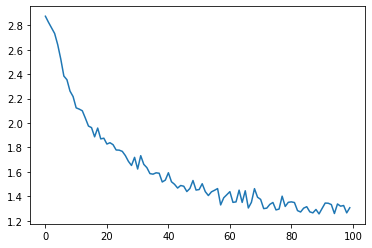

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### 결과 검증
다른 카테고리들에 대해 네트워크가 얼마나 잘 동작하는지 보기 위해, Confusion 매트릭스를 만든다.     
 모든 랭귀지들에(rows) 네트워크가 어떤 랭귀지를 추측(cols)하는지 나타낸다. 

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Top I :  tensor([[14]])
Top N :  tensor([[-1.3034]], grad_fn=<TopkBackward>)
Top I :  tensor([[16]])
Top N :  tensor([[-0.8296]], grad_fn=<TopkBackward>)
Top I :  tensor([[3]])
Top N :  tensor([[-0.6990]], grad_fn=<TopkBackward>)
Top I :  tensor([[1]])
Top N :  tensor([[-0.2749]], grad_fn=<TopkBackward>)
Top I :  tensor([[5]])
Top N :  tensor([[-1.2800]], grad_fn=<TopkBackward>)
Top I :  tensor([[5]])
Top N :  tensor([[-0.4866]], grad_fn=<TopkBackward>)
Top I :  tensor([[9]])
Top N :  tensor([[-0.1422]], grad_fn=<TopkBackward>)
Top I :  tensor([[6]])
Top N :  tensor([[-1.0407]], grad_fn=<TopkBackward>)
Top I :  tensor([[16]])
Top N :  tensor([[-0.2673]], grad_fn=<TopkBackward>)
Top I :  tensor([[10]])
Top N :  tensor([[-1.1210]], grad_fn=<TopkBackward>)
Top I :  tensor([[10]])
Top N :  tensor([[-0.9532]], grad_fn=<TopkBackward>)
Top I :  tensor([[2]])
Top N :  tensor([[-1.6084]], grad_fn=<TopkBackward>)
Top I :  tensor([[1]])
Top N :  tensor([[-0.377

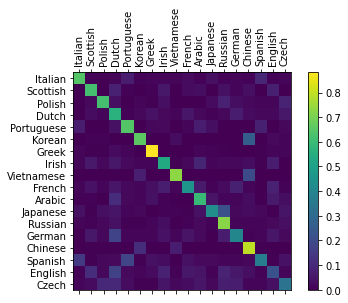

In [34]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
  hidden = rnn.initHidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  return output

for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = categoryFromOutput(output)
  category_i = all_categories.index(category)
  confusion[category_i][guess_i] += 1

for i in range(n_categories):
  confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [35]:
def predict(input_line, n_predictions=3):
  print('\n> %s' % input_line)
  with torch.no_grad():
    output = evaluate(lineToTensor(input_line))

    # Get top N categories
    topv, topi = output.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
      value = topv[0][i].item()
      category_index = topi[0][i].item()
      print('(%.2f) %s' % (value, all_categories[category_index]))
      predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi') 


> Dovesky
(-0.30) Russian
(-2.18) Czech
(-2.51) Polish

> Jackson
(-1.12) Russian
(-1.27) English
(-1.58) Dutch

> Satoshi
(-0.53) Japanese
(-1.83) Arabic
(-2.30) Italian
